## Loop state inference for *Fbn2* TAD in mESCs

For this analysis, we use the data from [Gabriele et al (2022)](https://www.science.org/doi/10.1126/science.abn6583). The data analyzed in this notebook are the C36 (wild type) and C65 (control) strains.

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from traceHMM.model import TraceModel
from traceHMM.utils import plot as tplt

In [2]:
%reload_ext autoreload
%autoreload 2

### Analysis of C65 - the control group

#### Read in data

Please replace the `data_dire` with the relative path of the data stored on your machine.

In [3]:
data_dire = "../../../../gabriele_et_al_2023/data"
control_path = os.path.join(data_dire, "C65.tagged_set.tsv")
data = pd.read_csv(control_path, sep="\t")
print(f"{control_path.split("/")[-1]} has {len(pd.unique(data.id))} trajectories")
data.head()

C65.tagged_set.tsv has 147 trajectories


,id,t,x,y,z,x2,y2,z2,dist,movie_index
0,0,1,33.384880,28.749708,1.267213,32.952367,29.029923,1.462896,0.551252,2020_09_03_movie1-03
1,0,2,33.377873,28.654452,1.225418,32.798974,28.968542,1.258580,0.659452,2020_09_03_movie1-03
2,0,3,33.347297,28.501661,1.093382,32.748908,28.775660,1.172601,0.662888,2020_09_03_movie1-03
3,0,4,33.410479,28.231071,1.050455,32.805305,28.571315,1.108860,0.696716,2020_09_03_movie1-03
4,0,7,33.661071,28.774886,1.453220,33.162907,28.963981,1.377385,0.538214,2020_09_03_movie1-03


Reformat the data from long to wide via pivot then fit the model. Here we assume there are three states: looped state, intermediate state, and unlooped state, denoted by 0, 1, and 2, respectively.

For the model, we assume the distance at each state follows a normal distribution with means and standard deviations (in µm) listed in `dist_params`.

For the transition matrix, since we don't want the chain jumps directly either from looped to unlooped or from unlooped to looped, initializing the corners of the matrix to 0 will ensure they are not updated during fitting.

In [4]:
many_available_ids = data.groupby("id").count().sort_values("t").index[-150:]
sub_data = data[data.id.isin(many_available_ids.values)]

pivoted = sub_data.pivot(index="t", columns="id", values="dist")
X = pivoted.values.T
dist_params = (
    {"loc":0.15, "scale":0.1},
    {"loc":0.3, "scale":0.2},
    {"loc":0.45, "scale":0.1}
)
P = np.array([
    [-1, -1,  0],
    [-1, -1, -1],
    [ 0, -1, -1]
])
tm3 = TraceModel(X=X, Pm=P, dist_params=dist_params)
tm3.fit(max_iter=200)

Converged at iteration 85


There is a `convergence` attribute for `TraceModel`, which records the mean absolute difference of the transition matrix between two consecutive iterations. We can plot this difference to see the convergence of the model.

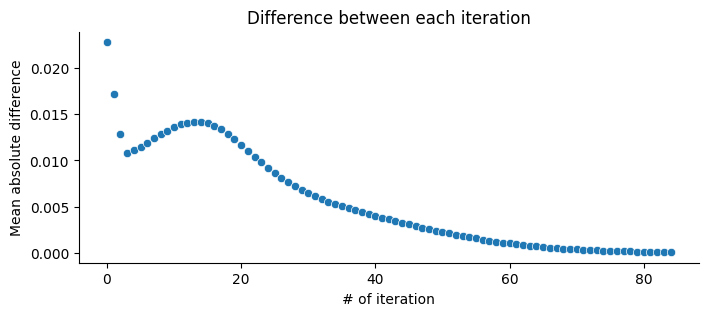

In [5]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.scatterplot(tm3.convergence, ax=ax)
ax.set(
    xlabel="# of iteration",
    ylabel="Mean absolute difference",
    title="Difference between each iteration"
)
plt.show()

#### Plot the fitted transition matrix

We can see that the corner elements are indeed fixed and are not updated. Moreover, the stationary distribution shows that in the long run, the trace only spends 4.5% of its time in the looped state. This coincides with the experiment design as C65 is the control group.

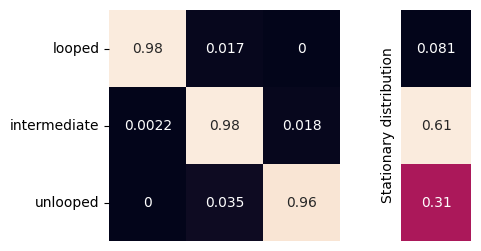

In [6]:
fig = tplt.plot_transition_matrix(tm3.P)

#### Plot some sample trajectories

In [7]:
# some trace IDs in the data
pd.unique(data.id)[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Note the decode method only accepts two-dimensional numpy array, with each row being one trace.

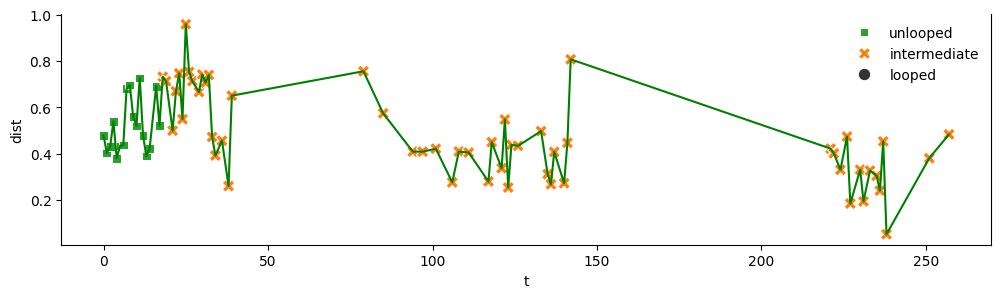

In [8]:
code_book = {0:"looped", 1:"intermediate", 2:"unlooped"}
df = data[data.id==1].copy()
df["state"] = tm3.decode(df["dist"].values[None,:])[0]
fig, ax = tplt.plot_trace(df, "t", "dist", "state", code_book)

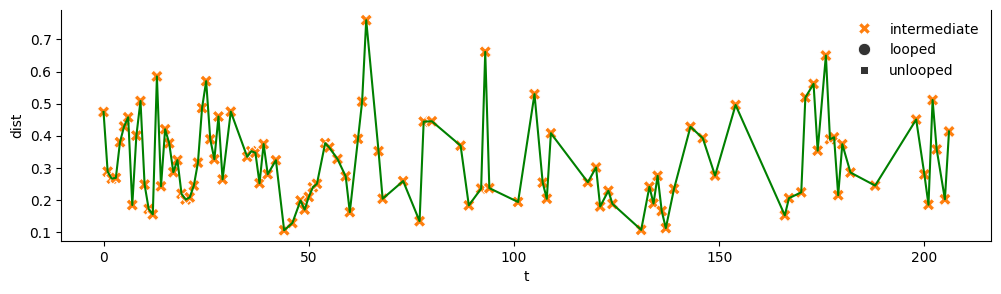

In [9]:
df = data[data.id==6].copy()
df["state"] = tm3.decode(df["dist"].values[None,:])[0]
fig, ax = tplt.plot_trace(df, "t", "dist", "state", code_book)

### Analysis of C36 - the experiment group

Here we just repeat the same analysis for C65 and see if there are any difference.

In [10]:
experiment_path = os.path.join(data_dire, "C36.tagged_set.tsv")
data = pd.read_csv(experiment_path, sep="\t")
print(f"{experiment_path.split("/")[-1]} has {len(pd.unique(data.id))} trajectories")
data.head()

C36.tagged_set.tsv has 491 trajectories


,id,t,x,y,z,x2,y2,z2,dist,movie_index
0,0,6,21.402718,28.628556,5.736118,21.410426,28.615074,5.612181,0.124906,2020_08_31_movie1-03
1,0,7,21.842653,28.646646,5.347591,21.865756,28.661069,5.405542,0.064032,2020_08_31_movie1-03
2,0,9,21.699202,28.473489,5.245348,21.678237,28.464744,5.218815,0.034929,2020_08_31_movie1-03
3,0,10,21.706599,28.822224,5.717446,21.709891,28.841900,5.522071,0.196391,2020_08_31_movie1-03
4,0,11,22.203565,28.649616,5.512207,22.193264,28.564196,5.497887,0.087223,2020_08_31_movie1-03


In [11]:
many_available_ids = data.groupby("id").count().sort_values("t").index[-150:]
sub_data = data[data.id.isin(many_available_ids.values)]

pivoted = sub_data.pivot(index="t", columns="id", values="dist")
X = pivoted.values.T
dist_params = (
    {"loc":0.15, "scale":0.1},
    {"loc":0.3, "scale":0.2},
    {"loc":0.45, "scale":0.1}
)
P = np.array([
    [-1, -1,  0],
    [-1, -1, -1],
    [ 0, -1, -1]
])
tme = TraceModel(X=X, Pm=P, dist_params=dist_params)
tme.fit(max_iter=200)

Converged at iteration 77


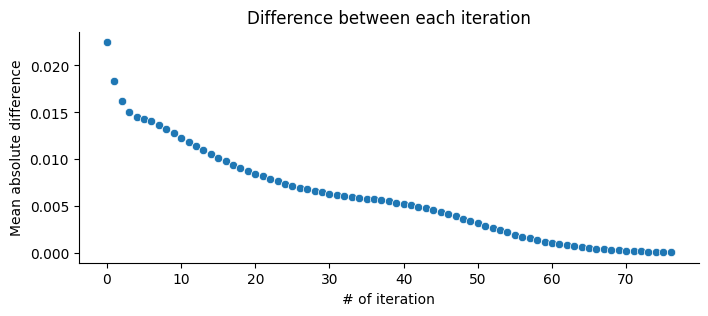

In [12]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.scatterplot(tme.convergence, ax=ax)
ax.set(
    xlabel="# of iteration",
    ylabel="Mean absolute difference",
    title="Difference between each iteration"
)
plt.show()

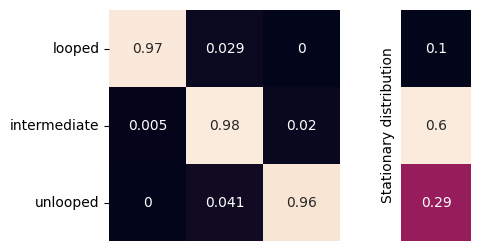

In [13]:
fig = tplt.plot_transition_matrix(tme.P)

In [14]:
pd.unique(sub_data.id)[10:20]

array([22, 34, 37, 39, 40, 44, 48, 52, 56, 59])

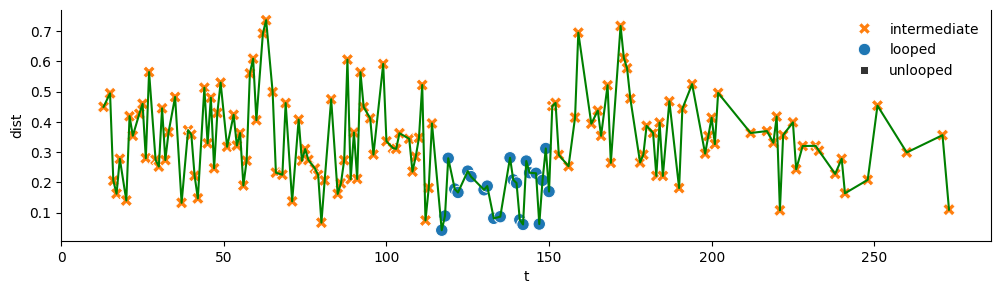

In [15]:
df = sub_data[sub_data.id==34].copy()
df["state"] = tme.decode(df["dist"].values[None,:])[0]
fig, ax = tplt.plot_trace(df, "t", "dist", "state", code_book)